In [1]:
from path import Path
import json
from itertools import chain

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
REACT_ISSUES_DIR_PATH = Path('react_issues/')


issues = []

for issue_path in REACT_ISSUES_DIR_PATH.glob('*.json'):
    with issue_path.open() as issue_file:
        issue_properties = json.load(issue_file)
        issues.append((
            issue_properties['title'], 
            issue_properties['body'], 
            issue_properties['user'], 
            issue_properties['has_pr'], 
            issue_properties['labels']
        ))

issues = pd.DataFrame.from_records(issues, columns=['title', 'body', 'user', 'pr', 'labels'])
issues['body'] = issues['body'].fillna('')
train_issues, val_issues = train_test_split(issues)

In [4]:
COMPONENT_PREFIX = 'Component: '


all_labels = set(chain(*issues['labels']))
component_labels = [label for label in all_labels if label.startswith(COMPONENT_PREFIX)]

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer


stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')


def extract_tokens(string):
    tokens = word_tokenize(string)
    return [
        stemmer.stem(token.lower())
        for token in word_tokenize(string)
        if token.isalpha() and token not in stop_words
    ]

In [6]:
def extract_targets(subset):
    return [
        np.float32([target_label in issue_labels for issue_labels in subset['labels']])
        for target_label in component_labels
    ]

train_targets = extract_targets(train_issues)
val_targets = extract_targets(val_issues)

In [7]:
for label, values in zip(component_labels, train_targets):
    print(f'Positive share for {label:40}: {values.mean():.6f}')

Positive share for Component: Server Rendering             : 0.002651
Positive share for Component: Scheduler                    : 0.000204
Positive share for Component: Scheduling Profiler          : 0.000408
Positive share for Component: Core Utilities               : 0.004554
Positive share for Component: Suspense                     : 0.001291
Positive share for Component: Flight                       : 0.000068
Positive share for Component: ReactIs                      : 0.000068
Positive share for Component: Developer Tools              : 0.020188
Positive share for Component: Optimizing Compiler          : 0.000204
Positive share for Component: Concurrent Mode              : 0.001835
Positive share for Component: Shallow Renderer             : 0.001291
Positive share for Component: Component API                : 0.001427
Positive share for Component: Fast Refresh                 : 0.000136
Positive share for Component: Build Infrastructure         : 0.010740
Positive share for C

Very few examples are positive for each label, class weights are required.

In [8]:
train_users = set(train_issues['user'])
val_users = set(val_issues['user'])
len(train_users), len(val_users), len(train_users & val_users)

(6434, 2502, 928)

Sets of users differ too much between the training and testing datasets.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder


feature_extractor = ColumnTransformer([
    ('title_vectorizer', TfidfVectorizer(analyzer=extract_tokens), 'title'),
    ('body_vectorizer', TfidfVectorizer(analyzer=extract_tokens), 'body')
])

In [10]:
train_features = feature_extractor.fit_transform(train_issues)
val_features = feature_extractor.transform(val_issues)

In [11]:
metrics_table_columns = ['label', 'precision', 'recall', 'f1']

def train_classifiers(model_factory):
    models, metrics = [], []
    for target_label, train_target, val_target in zip(component_labels, train_targets, val_targets):
        try:
            model = model_factory()
            model.fit(train_features, train_target)
            models.append(model)
            
            train_pred = model.predict(train_features)
            train_prec = precision_score(train_target, train_pred, zero_division=0)
            train_rec = recall_score(train_target, train_pred, zero_division=0)
            train_f1 = f1_score(train_target, train_pred, zero_division=0)

            val_pred = model.predict(val_features)
            val_prec = precision_score(val_target, val_pred, zero_division=0)
            val_rec = recall_score(val_target, val_pred, zero_division=0)
            val_f1 = f1_score(val_target, val_pred, zero_division=0)
            metrics.append([target_label, val_prec, val_rec, val_f1])
            print(f'{train_prec:.3f} {train_rec:.3f} {train_f1:.3f} {val_prec:.3f} {val_rec:.3f} {val_f1:.3f}')
        except Exception as e:
            print(f'Error training for "{target_label}": {e}')
            models.append(None)
            metrics.append((target_label, 0., 0., 0.))
    metrics = pd.DataFrame.from_records(metrics, columns=metrics_table_columns)
    return models, metrics

In [12]:
from sklearn.linear_model import LogisticRegression


log_reg_model, log_reg_metrics = train_classifiers(
    lambda: LogisticRegression(penalty='l2', C=.05, class_weight={0.: 1, 1.: 100}))

0.406 1.000 0.578 0.133 0.235 0.170
1.000 0.667 0.800 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
0.604 1.000 0.753 0.200 0.074 0.108
0.463 1.000 0.633 0.333 0.222 0.267
0.000 0.000 0.000 0.000 0.000 0.000
0.000 0.000 0.000 0.000 0.000 0.000
0.476 1.000 0.645 0.396 0.899 0.550
1.000 1.000 1.000 0.000 0.000 0.000
0.771 1.000 0.871 0.750 0.231 0.353
0.328 1.000 0.494 0.062 0.200 0.095
1.000 1.000 1.000 0.000 0.000 0.000
0.000 0.000 0.000 0.000 0.000 0.000
0.165 1.000 0.284 0.062 0.462 0.110
0.889 1.000 0.941 0.000 0.000 0.000
0.672 1.000 0.804 0.000 0.000 0.000
0.138 1.000 0.242 0.092 0.804 0.165
0.412 1.000 0.584 0.143 0.273 0.187
0.237 0.978 0.381 0.076 0.417 0.128
0.527 1.000 0.691 0.062 0.071 0.067


In [13]:
from sklearn.svm import SVC


svm_model, svm_metrics = train_classifiers(lambda: SVC(C = .05, class_weight={0: .1, 1: 100}))

0.368 1.000 0.538 0.048 0.118 0.068
1.000 1.000 1.000 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
0.023 1.000 0.045 0.017 0.630 0.033
0.576 1.000 0.731 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
0.026 1.000 0.051 0.023 1.000 0.046
1.000 1.000 1.000 0.000 0.000 0.000
0.844 1.000 0.915 0.667 0.154 0.250
0.311 1.000 0.475 0.059 0.200 0.091
1.000 1.000 1.000 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
0.011 1.000 0.021 0.008 1.000 0.016
0.457 1.000 0.627 0.000 0.000 0.000
0.147 1.000 0.256 0.034 0.120 0.053
0.026 1.000 0.051 0.023 1.000 0.045
0.408 1.000 0.580 0.105 0.182 0.133
0.158 1.000 0.273 0.028 0.250 0.051
0.539 1.000 0.701 0.056 0.071 0.062


In [14]:
from catboost import CatBoostClassifier


gb_model, gb_metrics = train_classifiers(lambda: CatBoostClassifier(
    verbose=False, n_estimators=32, reg_lambda=100, class_weights=[0.1, 10]))

0.145 0.821 0.246 0.129 0.529 0.207
1.000 1.000 1.000 0.000 0.000 0.000
0.857 1.000 0.923 0.000 0.000 0.000
0.492 0.463 0.477 0.000 0.000 0.000
0.190 1.000 0.319 0.143 0.556 0.227
1.000 1.000 1.000 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
0.352 0.923 0.509 0.298 0.865 0.444
1.000 1.000 1.000 1.000 0.400 0.571
0.628 1.000 0.771 0.571 0.308 0.400
0.244 1.000 0.392 0.053 0.200 0.083
0.913 1.000 0.955 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
0.031 0.962 0.060 0.019 0.795 0.036
0.941 1.000 0.970 0.000 0.000 0.000
0.703 0.578 0.634 0.000 0.000 0.000
0.029 1.000 0.056 0.025 0.991 0.049
0.172 0.950 0.291 0.075 0.455 0.128
0.077 0.822 0.140 0.042 0.583 0.079
0.253 0.812 0.386 0.120 0.429 0.188


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
log_reg_metrics['model'] = 'Logistic Regression'
gb_metrics['model'] = 'Boosting'
svm_metrics['model'] = 'SVM'
all_metrics = pd.concat([log_reg_metrics, gb_metrics, svm_metrics])

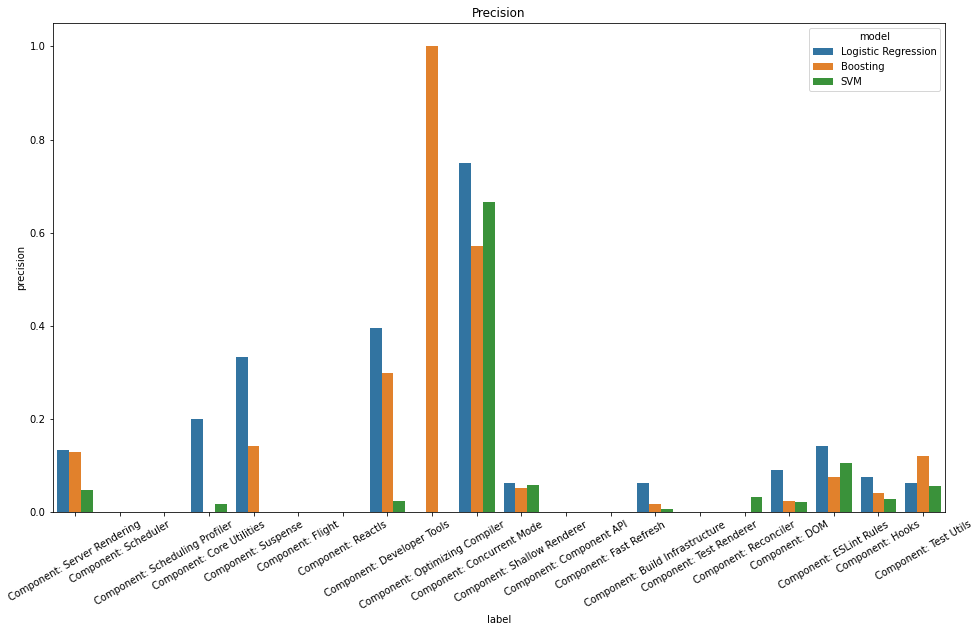

In [17]:
plt.figure(figsize=(16, 9))
prec_plot = sns.barplot(data=all_metrics, x='label', y='precision', hue='model')
prec_plot.set_title('Precision')
_ = prec_plot.set_xticklabels(prec_plot.get_xticklabels(), rotation=30)

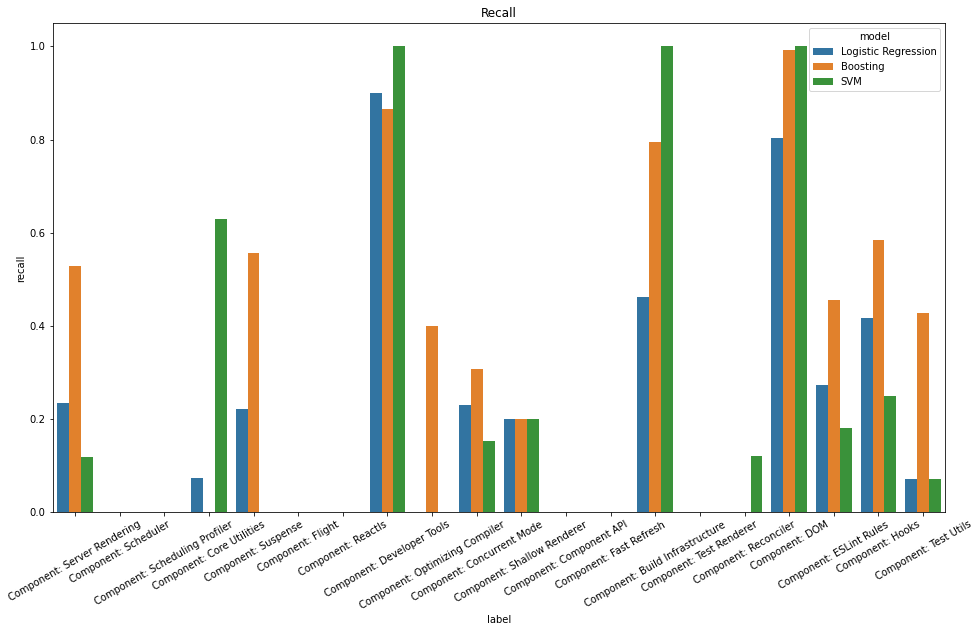

In [18]:
plt.figure(figsize=(16, 9))
prec_plot = sns.barplot(data=all_metrics, x='label', y='recall', hue='model')
prec_plot.set_title('Recall')
_ = prec_plot.set_xticklabels(prec_plot.get_xticklabels(), rotation=30)

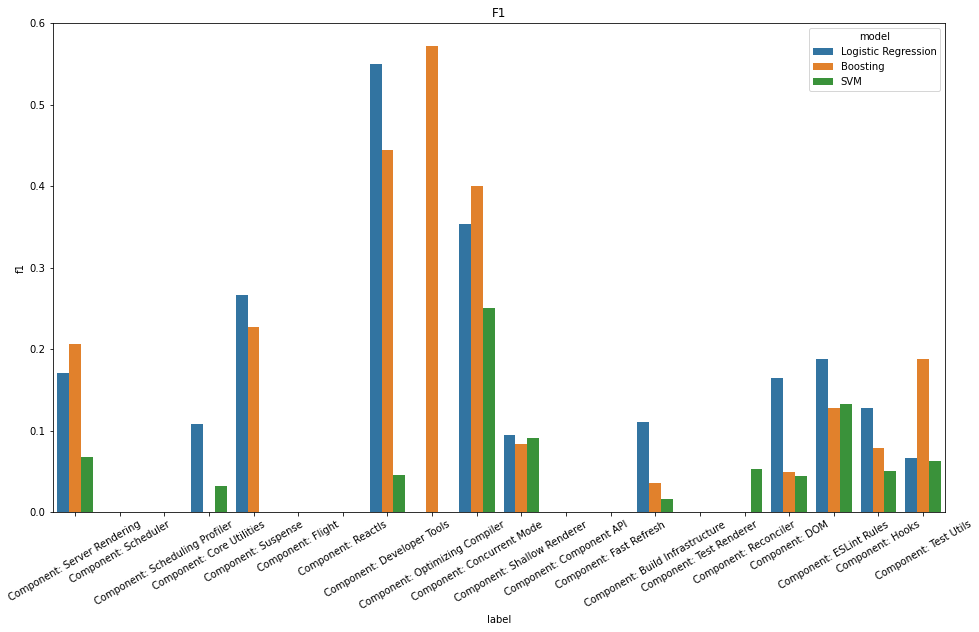

In [19]:
plt.figure(figsize=(16, 9))
prec_plot = sns.barplot(data=all_metrics, x='label', y='f1', hue='model')
prec_plot.set_title('F1')
_ = prec_plot.set_xticklabels(prec_plot.get_xticklabels(), rotation=30)